# Artificial Intelligence for Games

### Environment Setup

In [272]:
%run ../../../utilities/reinforcement_learning/environments/crypto_pair_trading_environment.ipynb

In [273]:
import pickle

In [274]:
model_file_path = '../../market_trading/data/featurized_market_data.p' 

with open(model_file_path, 'rb') as fp:
    featurized_market_data = pickle.load(fp)

In [275]:
pair_name = 'AAVE_BTC'
pair_data = featurized_market_data[pair_name]

# This dataset contains open, close, high, low, volume and any numerical features / indicators you like.
price_movement_df = pair_data

In [276]:
env = CryptoPairTradingEnv(pair_data, pair_name)

### Genetic Algorithms

#### Imports

In [277]:
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython import display

#### Utilities

In [278]:
class Chromosome():
    def __init__(self, genes, genome_length, fitness=0, default_gene=0):
        self.genes = genes.copy()
        self.genome_length = genome_length
        self.default_gene = default_gene
        self.fitness = fitness
        
        while len(self.genes) < genome_length:
            self.genes.append(default_gene)
            
    def crossover(self, mate, min_gene_value, max_gene_value, mutation_rate=0.1):
        offspring_genes = []
        
        # Simple cross-over function based on a 50% probability to take either parent's genes.
        for gene_index in range(self.genome_length):
            if np.random.rand() <= 0.5:
                offspring_genes.append(self.genes[gene_index])
            else:
                offspring_genes.append(mate.genes[gene_index])
                
        # Mutation
        for gene_index in range(self.genome_length):
            if np.random.rand() <= mutation_rate:
                offspring_genes[gene_index] = np.random.randint(low=min_gene_value, high=(max_gene_value + 1))
        
        return Chromosome(offspring_genes, self.genome_length, self.default_gene)

In [279]:
class GeneticEnvOptimizer():
    def __init__(self, env, min_gene_value, max_gene_value, population_size=100):
        self.population_size = population_size
        self.env = env
        self.min_gene_value = min_gene_value
        self.max_gene_value = max_gene_value
        self.__reset__()

    def __reset__(self):
        self.population = self.__generate_population__(self.population_size)

    def __generate_population__(self, population_size):
        print(f'Generating a population size of {population_size}.')
        
        population = []
        
        for index in range(population_size):
            state = env.reset()
            done = False
            actions = []
            episode_reward = 0
            
            while not done:
                action = env.action_space.sample()
                state, reward, done, info = env.step(action)
                episode_reward += reward
                actions.append(action)
                
            population.append(Chromosome(actions, env.data.shape[0] - 1, fitness=episode_reward))
            
        return population

    def __calculate_population_fitness__(self, population):
        for genome in population:
            state = env.reset()
            done = False
            actions = []
            episode_reward = 0
            
            while not done:
                action = env.action_space.sample()
                state, reward, done, info = env.step(action)
                episode_reward += reward
                actions.append(action)
                
            genome.fitness = episode_reward

    def __genome_sorting_key__(self, genome):
        return genome.fitness

    def __population_by_highest_fitness_in_place__(self):
        self.population.sort(key=self.__genome_sorting_key__, reverse=True)

    def __perform_selection__(self, population):
        new_population = []
        
        for left_parent_genome in population:
            for right_parent_genome in population:
                new_population.append(left_parent_genome.crossover(right_parent_genome, min_gene_value=self.min_gene_value, max_gene_value=self.max_gene_value))
        
        self.__calculate_population_fitness__(new_population)
        new_population.sort(key=self.__genome_sorting_key__, reverse=True)
        return new_population[:self.population_size]

    def optimize(self, is_initial_run=False):
        if is_initial_run:
            self.__reset__()

        self.__population_by_highest_fitness_in_place__()
        offspring = self.__perform_selection__(self.population)
        self.population = self.population[:3] + offspring[3:len(offspring)-3]

#### Sample Run

In [280]:
optimizer = GeneticEnvOptimizer(env, population_size=25, min_gene_value=min([ key.value for key in Actions ]), max_gene_value=max([ key.value for key in Actions ]))
generations = 10
fitness_scores = []

Generating a population size of 25.


C:\Users\divanma\.conda\envs\windows-ml-station\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


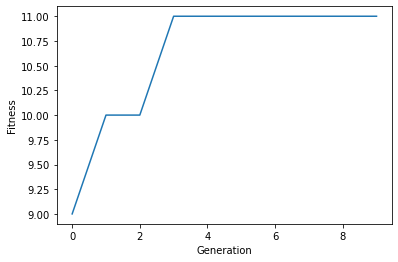

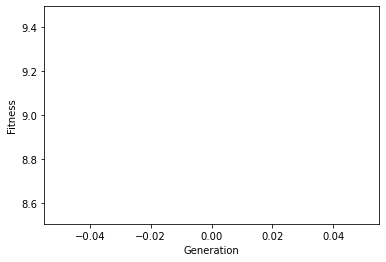

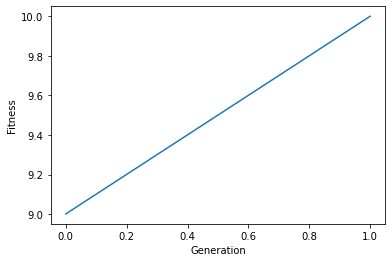

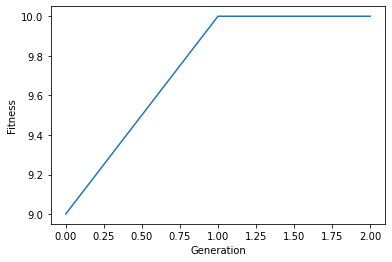

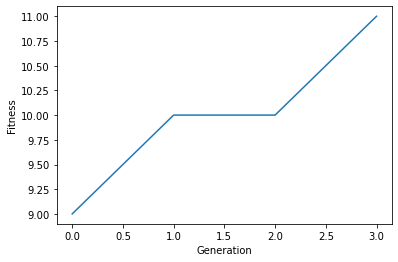

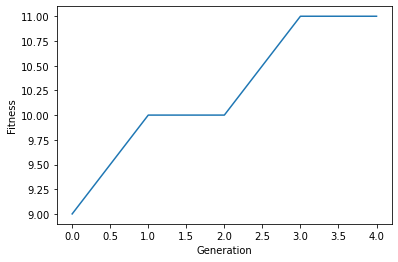

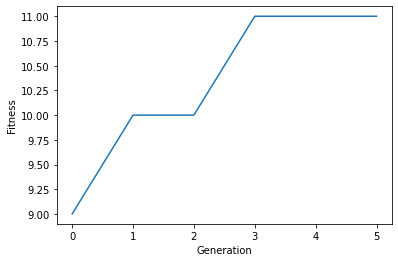

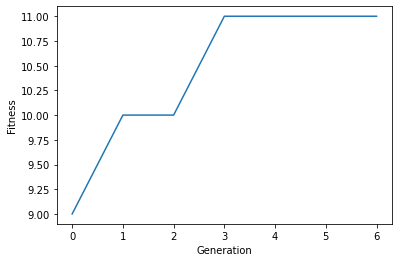

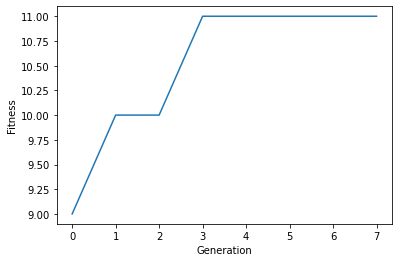

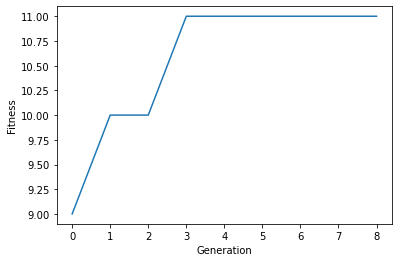

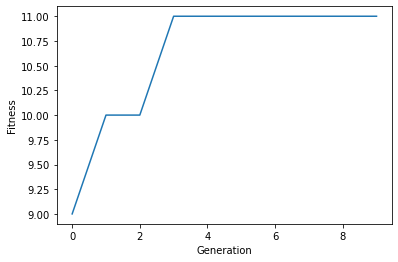

In [ ]:
for generation_index in range(generations):
    optimizer.optimize(is_initial_run=generation_index==0)
    fitness_scores.append(optimizer.population[0].fitness)
    fig, (ax1) = plt.subplots(1)
    ax1.plot(fitness_scores)
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Fitness')
    display.clear_output(wait=True)
    display.display(plt.gcf())

### Q-Learning

#### Formula

Q(s, a) = R(s, a) + yΣ(P(s,a,s')V(s'))

The quality of taking an action, given a state (Q(s,a)) is equal to the reward of the respective state and the action + the gamma/discount factor (probability of taking random actions to explore as opposed to taking a policy-based action) multiplied by the sum of all probabilities of the respective state, action and future states, multiplied by the value of those future states.

Q(s, a) = R(s, a) + yΣ(P(s,a,s') max Q(s', a'))

#### Temporal Difference

There is lots of non-deterministic (stochastic environment) searching happening in Q-learning. The temporal difference allows for agents to calculate the value of future states given an action.

TD(a, s) = R(s, a) + y max Q(s', a') - Q(s, a)

Where Q(s, a) is the quality of the previous state and action and the rest is the calculations for the current state. In theory the two should be the same as the one is the formulat for the other however we ususally calculate the Q of a state and action in advance where as here, we have the Q from experience and due to the environment being stochastic, these could be different. That difference is refered to as the temporal difference.

Q(s, a) = Q(s, a) + αTD(a, s)

This means the new Q function is the Q of the previous state and action + the temporal difference between the previous and current state, multiplied by alpha. Where alpha is the learning rate. To represent time, the equation can be updated to:

Qt(s, a) = Qt-1(s, a) + αTDt(a, s)

With the above in mind, the full equation can be updated to:
Qt(s, a) = Qt-1(s, a) + α(R(s, a) + y max Q(s', a') - Qt-1(s, a))

#### Deep Q Learning

Loss = Σ(Q_target - Q_actual)^2

In [ ]:
# Import dependencies.
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

In [ ]:
# Build the network.
def build_network(n_inputs, n_outputs, learning_rate=0.001):
    network = Sequential()
    
    # Add layers.
    network.add(Dense(units=32, activation='relu', input_shape=(n_inputs,)))
    network.add(Dense(units=16, activation='relu'))
    network.add(Dense(units=n_outputs))
    network.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    
    return network

In [ ]:
class ExperienceMemory():
    def __init__(self, memory_size, discount):
        self.memory_size = memory_size
        self.discount = discount
        self.memory = list()
        
    def remember(self, transition, terminal=False):
        self.memory.append([ transition, terminal ])
        
        # Remove the oldest experience when the buffer is full.
        if len(self.memory) > self.memory_size:
            del self.memory[0]
            
    # Get batches of inputs and targets.
    def get_batch(self, model, batch_size):
        memory_length = len(self.memory)
        # Memory > transition > current state (input to network) > columns / inputs.
        n_inputs = self.memory[0][0][0].shape[1]
        # Get nr of neurons in the last (-1) layer.
        n_outputs = model.output_shape[-1]

        # Initialize inputs and targets.
        inputs = np.zeros((min(batch_size, memory_length), n_inputs))
        targets = np.zeros((min(batch_size, memory_length), n_outputs))
        experience_length = np.random.randint(low=0, high=memory_length, size=min(batch_size, memory_length))
        experiences = [ self.memory[experience_index] for experience_index in experience_length]
        
        experience_current_batch_to_predict = np.array([ experience[0][0] for experience in experiences ])
        experience_current_predictions = model.predict_on_batch(experience_current_batch_to_predict)
        
        experience_next_batch_to_predict = np.array([ experience[0][3] for experience in experiences ])
        experience_next_predictions = model.predict_on_batch(experience_next_batch_to_predict)

        for i, experience in enumerate(experiences):
            current_state, action, reward, next_state = experience[0]
            terminal = experience[1]
            
            # Update inputs and targets.
            inputs[i] = current_state
            targets[i] = experience_current_predictions[i]
            
            if terminal:
                targets[i][action] = reward
            else:
                targets[i][action] = reward + memory.discount * np.max(experience_next_predictions[i][0])
        
        return inputs, targets

Put everything together and run a test.

In [ ]:
import gym
import matplotlib.pyplot as plt

In [ ]:
alpha = 0.001 # Learning Rate
memory_size = 50000
memory_batch_size = 32
gamma = 0.9 # Discount
epsilon = 1. # Initially all actions are random. We will update this value as we go along.
epsilon_decay = 0.995# Multiply epsilon by this after each step as to lower the chance of taking random actions / take more intelligent actions as we progress.

In [ ]:
# Training environment.
env = gym.make('MountainCar-v0')
n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

In [ ]:
model = build_network(n_inputs, n_outputs, learning_rate=alpha)
memory = ExperienceMemory(memory_size, gamma)

Epoch 1 > Epsilon: 0.99003 > Total Reward: -200.0


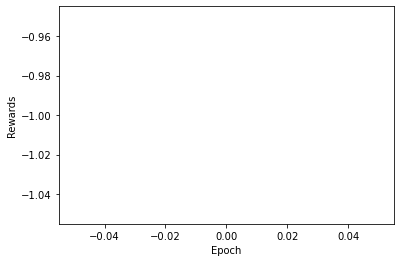

In [ ]:
# Initialize training.
epoch = 0
current_state = np.zeros((1, n_inputs))
next_state = current_state
total_reward = 0
rewards = list()

while epoch < 1:
    epoch += 1
    
    # Play the game.
    env.reset()
    current_state = np.zeros((1, n_inputs))
    next_state = current_state
    terminal = False
    
    while not terminal:
        # Take a random action when below the epsilon.
        if np.random.rand() <= epsilon:
            action = np.random.choice(env.action_space.n)
        # Take an intelligent action.
        else:
            q_values = model.predict(current_state)[0] # We only care about the columns so we select the first row.
            action = np.argmax(q_values) # Get the highest Q value predicted.

        # Update the environment.
        next_state[0], reward, terminal, info = env.step(action=action)
        total_reward += reward
        
        # Remember new experience.
        memory.remember([ current_state, action, reward, next_state ], terminal)
        
        # Train the AI and update the current state.
        inputs, targets = memory.get_batch(model=model, batch_size=memory_batch_size)
        model.train_on_batch(inputs, targets)
        
        current_state = next_state
        
    # Lower epsilon as to take less random actions as we progress.
    epsilon *= epsilon_decay
    
    print(f'Epoch {epoch} > Epsilon: {round(epsilon, 5)} > Total Reward: {round(total_reward, 2)}')
    
    rewards.append(reward)
    total_reward = 0

plt.plot(rewards)
plt.xlabel('Epoch')
plt.ylabel('Rewards')
plt.show()
env.close()

### References
- [Artificial Intelligence for Games Udemy Course](https://derivco.udemy.com/course/artificial-intelligence-for-simple-games/)
- [Markov Decision Processes: Concepts and Algorithms](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.329.1952&rep=rep1&type=pdf)
- [Learning to Predict by the Methods of Temporal Differences](https://link.springer.com/content/pdf/10.1007/BF00115009.pdf)
- [Berkeley University Pacman Project](http://ai.berkeley.edu/reinforcement.html)
- [PRIORITIZED EXPERIENCE REPLAY](https://arxiv.org/pdf/1511.05952.pdf)